In [4]:
# Append web folder to system path
import sys
sys.path.append('../web')

In [5]:
from db_config import Base
from Database import Station, Availability, Weather
from sqlalchemy import create_engine, func, Column, String, Integer, Double, Boolean
from sqlalchemy.orm import sessionmaker
import json
import sys

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pickle
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

In [8]:
# Get the db_info
with open('../dbinfo.json') as f:
    db_info = json.load(f)


USER = db_info['dbConnection']['USER']
PASSWORD = db_info['dbConnection']['PASSWORD']
URI = db_info['dbConnection']['URI']
PORT = db_info['dbConnection']['PORT']
DB = db_info['dbConnection']['DB']

# Create a new session
engine = create_engine(
    'mysql+pymysql://{}:{}@localhost:{}/{}'.format(USER, PASSWORD, PORT, DB), echo=True)
Base.metadata.create_all(bind=engine)
Session = sessionmaker(bind=engine)
session = Session()
print("connected")


2024-04-15 12:38:59,189 INFO sqlalchemy.engine.Engine SELECT DATABASE()
2024-04-15 12:38:59,190 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-15 12:38:59,222 INFO sqlalchemy.engine.Engine SELECT @@sql_mode
2024-04-15 12:38:59,223 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-15 12:38:59,244 INFO sqlalchemy.engine.Engine SELECT @@lower_case_table_names
2024-04-15 12:38:59,246 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-15 12:38:59,280 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-15 12:38:59,281 INFO sqlalchemy.engine.Engine DESCRIBE `db_on_your_bike`.`stations`
2024-04-15 12:38:59,282 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-15 12:38:59,300 INFO sqlalchemy.engine.Engine DESCRIBE `db_on_your_bike`.`availability`
2024-04-15 12:38:59,301 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-15 12:38:59,318 INFO sqlalchemy.engine.Engine DESCRIBE `db_on_your_bike`.`weather`
2024-04-15 12:38:59,319 INFO sqlalchemy.engine.Engine [raw sql] {}
2024-04-15 12:38:5

In [9]:
weather = session.query(Weather).all()

for row in weather:
    print(row.time_updated, row.type, row.temperature, row.humidity, row.type)


2024-04-15 12:39:01,689 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-15 12:39:01,697 INFO sqlalchemy.engine.Engine SELECT weather.time_updated AS weather_time_updated, weather.type AS weather_type, weather.description AS weather_description, weather.temperature AS weather_temperature, weather.feels_like AS weather_feels_like, weather.min_temp AS weather_min_temp, weather.max_temp AS weather_max_temp, weather.humidity AS weather_humidity, weather.wind_speed AS weather_wind_speed, weather.visibility AS weather_visibility, weather.clouds AS weather_clouds, weather.sunrise AS weather_sunrise, weather.sunset AS weather_sunset 
FROM weather
2024-04-15 12:39:01,698 INFO sqlalchemy.engine.Engine [generated in 0.00099s] {}
2024-02-20 16:05:05 Clouds 11.91 81 Clouds
2024-02-20 16:10:05 Clouds 11.96 80 Clouds
2024-02-20 16:15:05 Clouds 11.83 81 Clouds
2024-02-20 16:20:05 Clouds 11.96 80 Clouds
2024-02-20 16:25:05 Clouds 11.83 81 Clouds
2024-02-20 16:30:06 Clouds 11.67 79 Clouds
2024-02-

In [10]:
bike_availability = session.query(Availability).all()


2024-04-15 12:39:03,862 INFO sqlalchemy.engine.Engine SELECT availability.station_id AS availability_station_id, availability.time_updated AS availability_time_updated, availability.bike_stands AS availability_bike_stands, availability.available_bikes AS availability_available_bikes, availability.available_bike_stands AS availability_available_bike_stands, availability.status AS availability_status 
FROM availability
2024-04-15 12:39:03,866 INFO sqlalchemy.engine.Engine [generated in 0.00430s] {}


In [23]:
availability_df = pd.DataFrame([row.__dict__ for row in bike_availability])


In [24]:
availability_df.drop('_sa_instance_state', axis=1, inplace=True)
availability_df.to_csv('availability.csv')

In [25]:
availability_df = pd.read_csv('availability.csv')
availability_df['time_updated'] = pd.to_datetime(availability_df['time_updated'])
availability_df.head()

,Unnamed: 0,time_updated,available_bikes,status,available_bike_stands,station_id,bike_stands
0,0,2024-02-20 16:05:06,2,OPEN,29,1,31
1,1,2024-02-20 16:10:06,1,OPEN,30,1,31
2,2,2024-02-20 16:15:06,1,OPEN,30,1,31
3,3,2024-02-20 16:20:06,4,OPEN,26,1,31
4,4,2024-02-20 16:25:06,4,OPEN,26,1,31


In [26]:
availability_df.sort_values('time_updated', inplace=True)

In [27]:
weather_df = pd.DataFrame([row.__dict__ for row in weather])
weather_df.drop('_sa_instance_state', axis=1, inplace=True)
weather_df.sort_values('time_updated', inplace=True)
weather_df.head()

,type,temperature,min_temp,humidity,visibility,sunrise,feels_like,time_updated,description,max_temp,wind_speed,clouds,sunset
0,Clouds,11.91,11.53,81,10000,1708414464,11.27,2024-02-20 16:05:05,few clouds,12.36,9.77,20,1708451020
1,Clouds,11.96,11.53,80,10000,1708414464,11.30,2024-02-20 16:10:05,few clouds,12.36,9.77,20,1708451020
2,Clouds,11.83,11.05,81,10000,1708414464,11.18,2024-02-20 16:15:05,few clouds,12.36,9.77,20,1708451020
3,Clouds,11.96,11.53,80,10000,1708414464,11.30,2024-02-20 16:20:05,few clouds,12.36,9.77,20,1708451020
4,Clouds,11.83,11.05,81,10000,1708414464,11.18,2024-02-20 16:25:05,few clouds,12.36,9.77,20,1708451020


In [28]:
weather_df.to_csv('weather.csv')

In [29]:
df = pd.merge_asof(availability_df, weather_df, on='time_updated')

In [30]:
df = df[['station_id', 'time_updated', 'available_bikes', 'available_bike_stands', 'temperature', 'wind_speed', 'humidity', 'type']]
df.head()

,station_id,time_updated,available_bikes,available_bike_stands,temperature,wind_speed,humidity,type
0,1,2024-02-20 16:05:06,2,29,11.91,9.77,81,Clouds
1,90,2024-02-20 16:05:06,36,4,11.91,9.77,81,Clouds
2,89,2024-02-20 16:05:06,10,30,11.91,9.77,81,Clouds
3,88,2024-02-20 16:05:06,2,28,11.91,9.77,81,Clouds
4,87,2024-02-20 16:05:06,5,33,11.91,9.77,81,Clouds


In [31]:
df.dtypes

station_id                        int64
time_updated             datetime64[ns]
available_bikes                   int64
available_bike_stands             int64
temperature                     float64
wind_speed                      float64
humidity                          int64
type                             object
dtype: object

In [32]:
df.to_csv('weather_availability_joined.csv')

In [72]:
df = pd.read_csv('weather_availability_joined.csv')
# Convert station_id to int64
df['station_id'] = df['station_id'].astype('int64')

# Convert time_updated to datetime64
df['time_updated'] = pd.to_datetime(df['time_updated'])

# Convert available_bikes, available_bike_stands, and humidity to int64
df['available_bikes'] = df['available_bikes'].astype('int64')
df['available_bike_stands'] = df['available_bike_stands'].astype('int64')
df['humidity'] = df['humidity'].astype('int64')

# Convert temperature and wind_speed to float64
df['temperature'] = df['temperature'].astype('float64')
df['wind_speed'] = df['wind_speed'].astype('float64')


In [73]:
# One hot encode day of the week
df['weekday'] = df['time_updated'].dt.day_name()
df['hour'] = df['time_updated'].dt.hour
df['day'] = df['time_updated'].dt.day
one_hot_encoded_days = pd.get_dummies(df['weekday'])
df['rain'] = df['type'] == 'Rain'

df = pd.concat([df, one_hot_encoded_days], axis=1)

df.drop('time_updated', axis = 1, inplace=True)
df.drop('weekday', axis = 1, inplace=True)
df.drop('Unnamed: 0', axis = 1, inplace=True)
df.drop('type', axis=1, inplace=True)


df.head()

,station_id,available_bikes,available_bike_stands,temperature,wind_speed,humidity,hour,day,rain,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,2,29,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False
1,90,36,4,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False
2,89,10,30,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False
3,88,2,28,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False
4,87,5,33,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False


In [74]:
print(one_hot_encoded_days.columns)

Index(['Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')


In [75]:
df.head()

,station_id,available_bikes,available_bike_stands,temperature,wind_speed,humidity,hour,day,rain,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,1,2,29,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False
1,90,36,4,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False
2,89,10,30,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False
3,88,2,28,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False
4,87,5,33,11.91,9.77,81,16,20,False,False,False,False,False,False,True,False


In [76]:
from sklearn.metrics import mean_squared_error, r2_score

In [77]:
unique_station_ids = df['station_id'].unique()

r2_list = []

for station_id in unique_station_ids:

    temp_df = df[( df['station_id'] == station_id)]
    temp_train_df = temp_df.drop(['station_id', 'available_bikes', 'available_bike_stands'], axis=1)

    x_train, x_test, y_train, y_test = train_test_split(temp_train_df, temp_df['available_bike_stands'], test_size = 0.1, random_state=23)


    poly = PolynomialFeatures(degree=3, include_bias=False)
    poly_features = poly.fit_transform(x_train)

    poly_reg_model = LinearRegression()
    poly_reg_model.fit(poly_features, y_train)

    poly_test_features = poly.fit_transform(x_test)
    y_pred_test = poly_reg_model.predict(poly_test_features)
    r2 = r2_score(y_test, y_pred_test)
    r2_list.append(r2)
    print(r2)


    with open(f'station_{station_id}.pkl', 'wb') as file:
        # Serialize and save the model to the file
        pickle.dump(poly_reg_model, file)

temp_df.columns

0.7545701784701156
0.7070856549289659


0.6774686482003733
0.8212670391550992
0.8057880383597404
0.7928159488525877
0.7897318688265136
0.8159519249661862
0.829791232434759
0.7453664953913641
0.8195710871228958
0.6252819086319767
0.7285505961447418
0.6499158624235155
0.7170920082740067
0.7945464932606046
0.6768725491506941
0.6904226753380569
0.77952600739112
0.7144449843341212
0.672744283810134
0.7703452938640685
0.6800169718310345
0.7441572140741859
0.73557010601886
0.7038002292431498
0.7355918410242499
0.7578215680367324
0.731789791170232
0.8104889250110469
0.7175934489874557
0.8224869303554924
0.8058042161785732
0.6643710600186388
0.7994047620187393
0.6605421474400187
0.8138560077658472
0.6800335672506183
0.7487336308443118
0.7189740954041761
0.7026768439863059
0.7443799220615404
0.6992497251629066
0.7156542460375682
0.6565600626084102
0.7808102539819284
0.7027153637464074
0.7951268392867323
0.6676674305068565
0.8720932116584519
0.7352716819594152
0.7597181870367493
0.7642775659676039
0.7935407175315002
0.7297787885306367


Index(['station_id', 'available_bikes', 'available_bike_stands', 'temperature',
       'wind_speed', 'humidity', 'hour', 'day', 'rain', 'Friday', 'Monday',
       'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday'],
      dtype='object')

In [78]:
print(np.mean(r2_list))

0.7329813836019177


In [79]:
temp_train_df.columns

Index(['temperature', 'wind_speed', 'humidity', 'hour', 'day', 'rain',
       'Friday', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')

In [80]:
y_pred_train = poly_reg_model.predict(poly_features)

poly_test_features = poly.fit_transform(x_test)
y_pred_test = poly_reg_model.predict(poly_test_features)
r2 = r2_score(y_test, y_pred_test)
print(r2)

0.677641995891515


Text(0, 0.5, 'Predicted Available Bikes')

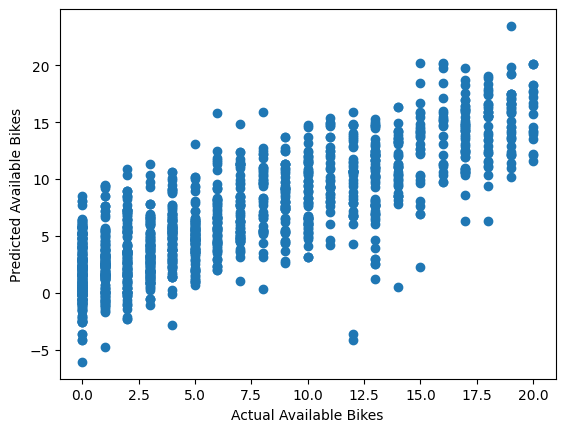

In [86]:
plt.scatter(y_test, y_pred_test)
plt.xlabel("Actual Available Bikes")
plt.ylabel("Predicted Available Bikes")

In [82]:
r2 = r2_score(y_test, y_pred_test)
print(r2)

0.677641995891515


In [83]:
with open('station_1.pkl', 'wb') as file:
    # Serialize and save the model to the file
    pickle.dump(poly_reg_model, file)

In [84]:
with open('station_1.pkl', 'rb') as file:
    # Load the model from the file
    poly_reg_model = pickle.load(file)


poly_reg_model.predict(poly_features)

array([4.46161956, 7.71526028, 6.8656257 , ..., 9.79895161, 2.01319683,
       4.12137823])

In [85]:
def get_stations(station_id):
    poly = PolynomialFeatures(degree=3, include_bias=False)
    with open(f'station_{station_id}.pkl', 'rb') as file:
        # Load the model from the file
        poly_reg_model = pickle.load(file)

    
    predictions = poly_reg_model.predict(poly_features)
    # row = session.query(Availability).filter_by(station_id=station_id)
    return predictions

get_stations(1)

array([4.46161956, 7.71526028, 6.8656257 , ..., 9.79895161, 2.01319683,
       4.12137823])